In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"

In [2]:
MM2M = 1e-3
KM2M = 1e3
Y2S = 365.25 * 24 * 60 * 60
MIN_GEOMETRIC_MOMENT = 1e-10
depth = 15e3
years = 100
reference_slip_deficit_rate = 30 * MM2M / Y2S  # mm/yr
n_pts = 1000
x = np.linspace(0, depth, n_pts)
segment_area = x[1] - x[0]
coseismic_slip_magnitude = 3.0
coseismic_slip = coseismic_slip_magnitude * np.cos(x / depth * np.pi / 2.0) ** 3.0
slip_deficit_rate = (
    reference_slip_deficit_rate * np.cos(x / depth * np.pi / 2.0) ** 0.25
)
accumulated_geometric_moment = slip_deficit_rate * years * Y2S * segment_area
coseismic_geometric_moment = coseismic_slip * segment_area
residual_geometric_moment_all = (
    accumulated_geometric_moment - coseismic_geometric_moment
)
residual_geometric_moment = residual_geometric_moment_all.copy()
residual_geometric_moment[residual_geometric_moment <= 0] = MIN_GEOMETRIC_MOMENT

In [3]:
def plot_geometric_moments_and_afterslip_velocities():
    # Geometric moments
    plt.figure(figsize=(10, 4.5))
    plt.subplot(1, 2, 1)

    fill_y = np.array([x, np.flip(x)]).flatten()
    fill_x = np.array(
        [accumulated_geometric_moment / segment_area, np.zeros(n_pts)]
    ).flatten()
    plt.fill(
        fill_x,
        fill_y / 1e3,
        color="cyan",
        label="accumulated",
        edgecolor=None,
    )

    fill_y = np.array([x, np.flip(x)]).flatten()
    fill_x = np.array(
        [-coseismic_geometric_moment / segment_area, np.zeros(n_pts)]
    ).flatten()
    plt.fill(
        fill_x,
        fill_y / 1e3,
        color="orange",
        label="coseismic",
        edgecolor=None,
    )

    fill_y = np.array([x, np.flip(x)]).flatten()
    fill_x = np.array(
        [residual_geometric_moment_all / segment_area, np.zeros(n_pts)]
    ).flatten()
    plt.fill(
        fill_x,
        fill_y / 1e3,
        color="black",
        label="residual",
        alpha=0.25,
        edgecolor=None,
    )

    fill_y = np.array([x, np.flip(x)]).flatten()
    fill_x = np.array([-m_afterslip_corrected, np.zeros(n_pts)]).flatten()
    plt.fill(
        fill_x,
        fill_y / 1e3,
        color="red",
        label="afterslip",
        alpha=0.5,
        edgecolor=None,
    )

    plt.plot(accumulated_geometric_moment / segment_area, x / KM2M, "-k", linewidth=0.5)
    plt.plot(-coseismic_geometric_moment / segment_area, x / KM2M, "-k", linewidth=0.5)
    plt.plot(
        residual_geometric_moment_all / segment_area, x / KM2M, "-k", linewidth=0.5
    )
    plt.plot(-m_afterslip_corrected, x / KM2M, "-k", linewidth=0.5)
    plt.plot(
        m_end_of_event,
        x / KM2M,
        "--k",
        color="k",
        linewidth=1.0,
        label="end of sequence",
    )
    plt.plot([0, 0], [0, 15], "-k", linewidth=0.5)

    plt.xlim(-4, 4)
    plt.ylim([0, 15])
    plt.yticks([0, 5, 10, 15])
    plt.gca().invert_yaxis()
    plt.xlabel("$m_i \; / \; a_i$ (m)")
    plt.ylabel("$d$ (km)")
    plt.legend(loc="lower left", frameon=False)

    # After-slip velocities
    plt.subplot(1, 2, 2)
    colors = plt.get_cmap("plasma_r")(np.linspace(0.0, 1.0, len(t)))
    for i in range(len(t)):
        plt.plot(v[:, i], x / 1e3, "-k", linewidth=0.5)
        fill_y = np.array([x, np.flip(x)]).flatten()
        fill_x = np.array([v[:, i], np.zeros(n_pts)]).flatten()
        plt.fill(
            fill_x,
            fill_y / 1e3,
            color=colors[i, 0:3],
            label="t = {:.2f} years".format(t[i] / Y2S),
        )
    plt.xlabel("$v$ (m / yr)")
    plt.ylabel("$d$ (km)")
    plt.yticks([0, 5, 10, 15])
    plt.ylim([0, 15])
    plt.gca().set_xlim(left=0.0)
    plt.gca().invert_yaxis()
    plt.legend(frameon=False)
    plt.savefig("kinematic_afterslip_m_velocities.pdf")
    plt.savefig("kinematic_afterslip_m_velocities.png", dpi=500)
    plt.show()

In [4]:
def calc_V(c, gamma, m_coseismic, g, h, f):
    numerator = c**2 * gamma * m_coseismic
    denominator = np.sum(g * h / f)
    V = numerator / denominator
    return V


def calc_v0(V, g, h):
    v0 = V * g * h
    return v0


def calc_m_afterslip(gamma, m_coseismic, g, h, f):
    numerator = gamma * g * h * m_coseismic
    denominator = f * np.sum(g * h / f)
    m_afterslip = numerator / denominator
    return m_afterslip

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_75634/156128855.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(


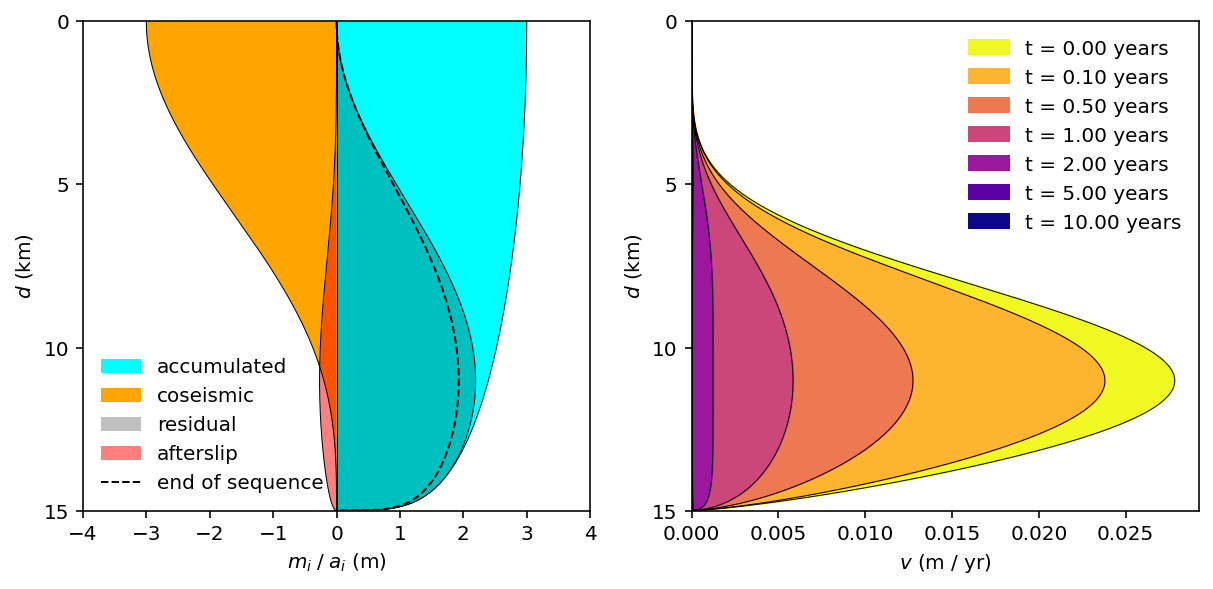

In [5]:
# Basics
gamma = 0.1
c = 0.00001
m_coseismic = np.sum(coseismic_geometric_moment / segment_area)

# Core function choices
f = residual_geometric_moment
g = residual_geometric_moment**3.0
h = m_coseismic

# Initial conditions
V = calc_V(c, gamma, m_coseismic, g, h, f)
v0 = calc_v0(V, g, h)

# Time to evaluate
# t = np.linspace(0, 10, 5) * Y2S
t = np.array([0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]) * Y2S

# Calculate afterslip velocities at specified times
v = np.zeros((n_pts, len(t)))
for i in range(len(t)):
    v[:, i] = v0 * np.exp(-(c**2.0) * f * segment_area * t[i])
v = v * Y2S  # Convert from m/s to m/yr

# Analytic geometric moment
m_afterslip = calc_m_afterslip(gamma, m_coseismic, g, h, f)
m_afterslip_corrected = np.zeros(n_pts)

# Analytic fterslip correction for non-negative areas
non_zero_segments = np.where(residual_geometric_moment > MIN_GEOMETRIC_MOMENT)[0]
m_afterslip_corrected[non_zero_segments] = np.sum(m_afterslip) / len(non_zero_segments)
m_afterslip_corrected = m_afterslip

# Geometric moment left at the end of the event and afterslip sequence
m_end_of_event = residual_geometric_moment_all / segment_area - m_afterslip

# Plot geometric moments and afterslip velocities
plot_geometric_moments_and_afterslip_velocities()

In [ ]:
# Geometric moments
plt.figure(figsize=(10, 4.5))
plt.subplot(1, 2, 1)

fill_y = np.array([x, np.flip(x)]).flatten()
fill_x = np.array(
    [accumulated_geometric_moment / segment_area, np.zeros(n_pts)]
).flatten()
plt.fill(
    fill_x,
    fill_y / 1e3,
    color="cyan",
    label="accumulated",
    edgecolor=None,
)

fill_y = np.array([x, np.flip(x)]).flatten()
fill_x = np.array(
    [-coseismic_geometric_moment / segment_area, np.zeros(n_pts)]
).flatten()
plt.fill(
    fill_x,
    fill_y / 1e3,
    color="orange",
    label="coseismic",
    edgecolor=None,
)

fill_y = np.array([x, np.flip(x)]).flatten()
fill_x = np.array(
    [residual_geometric_moment_all / segment_area, np.zeros(n_pts)]
).flatten()
plt.fill(
    fill_x,
    fill_y / 1e3,
    color="black",
    label="residual",
    alpha=0.25,
    edgecolor=None,
)


# fill_y = np.array([x, np.flip(x)]).flatten()
# fill_x = np.array([-m_afterslip_corrected, np.zeros(n_pts)]).flatten()
# plt.fill(
#         fill_x,
#         fill_y / 1e3,
#         color="red",
#         label="afterslip", alpha=0.5, edgecolor=None,
#     )

plt.plot(accumulated_geometric_moment / segment_area, x / KM2M, "-k", linewidth=0.5)
plt.plot(-coseismic_geometric_moment / segment_area, x / KM2M, "-k", linewidth=0.5)
plt.plot(residual_geometric_moment_all / segment_area, x / KM2M, "-k", linewidth=0.5)
# plt.plot(-m_afterslip_corrected / segment_area, x / KM2M, "-k", linewidth=0.5)
# plt.plot(m_end_of_event, x / KM2M, "-k", color="k", linewidth=1.0, label="end of sequence")
plt.plot([0, 0], [0, 15], "-k", linewidth=0.5)

plt.xlim(-4, 4)
plt.ylim([0, 15])
plt.yticks([0, 5, 10, 15])
plt.gca().invert_yaxis()
plt.xlabel("$m_i \; / \; a_i$ (m)")
plt.ylabel("$d$ (km)")
plt.legend(loc="lower left", frameon=False)

# After-slip velocities
plt.subplot(1, 2, 2)
colors = plt.get_cmap("plasma_r")(np.linspace(0.0, 1.0, len(t)))
for i in range(len(t)):
    plt.plot(v[:, i], x / 1e3, "-k", linewidth=0.5)
    fill_y = np.array([x, np.flip(x)]).flatten()
    fill_x = np.array([v[:, i], np.zeros(n_pts)]).flatten()
    plt.fill(
        fill_x,
        fill_y / 1e3,
        color=colors[i, 0:3],
        label="t = {:.2f} years".format(t[i] / Y2S),
    )
plt.xlabel("$v$ (m / yr)")
plt.ylabel("$d$ (km)")
# plt.xlim([, ])
plt.yticks([0, 5, 10, 15])
plt.ylim([0, 15])
plt.gca().set_xlim(left=0.0)
plt.gca().invert_yaxis()
plt.legend(frameon=False)
plt.savefig("residual_moment_schematic.pdf")
plt.savefig("residual_moment_schematic.png", dpi=500)
plt.show()

In [ ]:
coseismic_slip_magnitude = 2.5
coseismic_slip = coseismic_slip_magnitude * np.cos(x / depth * np.pi / 2.0) ** 1.0

for i in range(5):
    factor = 1 / ((i + 1) ** 3)
    coseismic_slip += (
        1 / (i + 1) * np.random.rand(1) * np.cos(x / depth * np.pi / factor) ** 1.0
    )

coseismic_slip *= np.cos(x / depth * np.pi / 2.0) ** 1.0
coseismic_slip[coseismic_slip < 0.0] = 0.0

slip_deficit_rate = reference_slip_deficit_rate * np.cos(x / depth * np.pi / 2.0) ** (
    0.25
)
accumulated_geometric_moment = slip_deficit_rate * years * Y2S * segment_area
coseismic_geometric_moment = coseismic_slip * segment_area
residual_geometric_moment_all = (
    accumulated_geometric_moment - coseismic_geometric_moment
)
residual_geometric_moment = residual_geometric_moment_all.copy()
residual_geometric_moment[residual_geometric_moment <= 0] = MIN_GEOMETRIC_MOMENT


# Basics
gamma = 0.1
c = 0.00001
m_coseismic = np.sum(coseismic_geometric_moment / segment_area)

# Core function choices
f = residual_geometric_moment
g = residual_geometric_moment**5.0
h = m_coseismic

# Initial conditions
V = calc_V(c, gamma, m_coseismic, g, h, f)
v0 = calc_v0(V, g, h)

# Time to evaluate
# t = np.linspace(0, 10, 5) * Y2S
t = np.array([0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]) * Y2S

# Calculate afterslip velocities at specified times
v = np.zeros((n_pts, len(t)))
for i in range(len(t)):
    v[:, i] = v0 * np.exp(-(c**2.0) * f * segment_area * t[i])
v = v * Y2S  # Convert from m/s to m/yr

# Analytic geometric moment
m_afterslip = calc_m_afterslip(gamma, m_coseismic, g, h, f)
m_afterslip_corrected = np.zeros(n_pts)

# Analytic fterslip correction for non-negative areas
non_zero_segments = np.where(residual_geometric_moment > MIN_GEOMETRIC_MOMENT)[0]
m_afterslip_corrected[non_zero_segments] = np.sum(m_afterslip) / len(non_zero_segments)
m_afterslip_corrected = m_afterslip

# Geometric moment left at the end of the event and afterslip sequence
m_end_of_event = residual_geometric_moment_all / segment_area - m_afterslip

# Plot geometric moments and afterslip velocities
plot_geometric_moments_and_afterslip_velocities()